In [1]:
import os
import pyvips
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

os.environ['VIPS_DISC_THRESHOLD'] = '10gb'

# Params
seed = 42

# Paths
root = '/media/latlab/MR/projects/kaggle-ubc-ocean'
data_dir = os.path.join(root, 'data')
results_dir = os.path.join(root, 'results')
train_csv = 'train.csv'
train_image_dir = os.path.join(data_dir, 'train_images')
train_thumbnail_dir = os.path.join(data_dir, 'train_thumbnails')
out_dir = os.path.join(results_dir, 'train_tiles_2048_p25_test_v1')
# v1: absolute basic tiling
# v2: white background
# v3: match TMA scale (black background)

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

def extract_image_tiles(p_img, folder, size: int = 2048, scale: float = 0.25, drop_thr: float = 0.85) -> list:
    im = pyvips.Image.new_from_file(p_img)
    
    # Match TMA scale (v3)
    if im.height < 5000 and im.width < 5000:
        w = h = size = size*2
        scale = scale/2
    else:
        w = h = size

    idxs = [(y, y + h, x, x + w) for y in range(0, im.height, h) for x in range(0, im.width, w)]
    files = []
    for k, (y, y_, x, x_) in enumerate(idxs):
        tile = im.crop(x, y, min(w, im.width - x), min(h, im.height - y)).numpy()[..., :3]
        mask_bg = np.sum(tile, axis=2) == 0
        if np.sum(mask_bg) >= (np.prod(mask_bg.shape) * drop_thr):
            continue

        if tile.shape[:2] != (h, w):
            tile_ = tile
            tile_size = (h, w) if tile.ndim == 2 else (h, w, tile.shape[2])
            tile = np.zeros(tile_size, dtype=tile.dtype)
            tile[:tile_.shape[0], :tile_.shape[1], ...] = tile_

        # # Make background white (v2)
        # black_bg = np.sum(tile, axis=2) == 0
        # tile[black_bg, :] = 255
        
        p_img = os.path.join(folder, f"{k:06}_{int(x_ / w)}-{int(y_ / h)}.png")
        new_size = int(size * scale), int(size * scale)
        Image.fromarray(tile).resize(new_size, Image.LANCZOS).save(p_img)
        files.append(p_img)
    return files, idxs

## Show the image tiles with segmentations for one test image

1
nb_rows=1
nb_cols=1
image size: (512, 512, 3)
92
nb_rows=10
nb_cols=12
image size: (512, 512, 3)


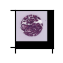

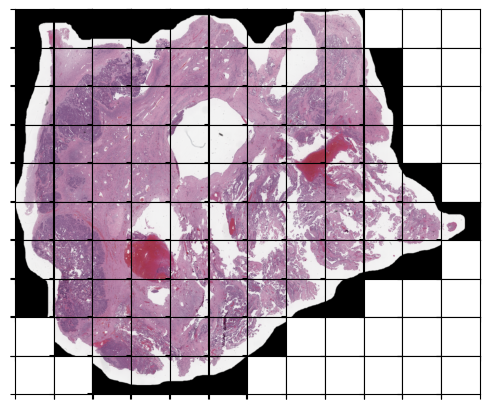

In [2]:
for test_img_id  in ['91', '4']:
    os.makedirs('/tmp/ubc', exist_ok=True)
    tiles_img, _ = extract_image_tiles(os.path.join(train_image_dir, f'{test_img_id}.png'), '/tmp/ubc', size=2048, scale=0.25, drop_thr=0.85)
    print(len(tiles_img))

    names = [os.path.splitext(os.path.basename(p_img))[0] for p_img in tiles_img]
    pos = [name.split("_")[-1] for name in names]
    idx_x, idx_y = zip(*[list(map(int, p.split("-"))) for p in pos])
    nb_rows = len(set(idx_y))
    nb_cols = len(set(idx_x))
    print(f"{nb_rows=}\n{nb_cols=}")

    fig, axes = plt.subplots(nrows=nb_rows, ncols=nb_cols,
        figsize=(nb_cols * 0.5, nb_rows * 0.5)
    )
    axes = np.array(axes).reshape(nb_rows, nb_cols)
    for p_img, x, y in zip(tiles_img, idx_x, idx_y):
        img = plt.imread(p_img)
        ax = axes[y - 1, x - 1]
        ax.imshow(img)
    print(f"image size: {img.shape}")

    for i in range(nb_rows):
        for j in range(nb_cols):
            axes[i, j].set_xticklabels([])
            axes[i, j].set_yticklabels([])

    plt.subplots_adjust(wspace=0, hspace=0)
    # # fig.tight_layout()

## Export all image tiles¶

In [3]:
def extract_prune_tiles(idx_path_img, folder, size: int = 2048, scale: float = 0.25, drop_thr: float = 0.85) -> None:
    idx, p_img = idx_path_img
    print(f"processing #{idx}: {p_img}")
    name, _ = os.path.splitext(os.path.basename(p_img))
    folder = os.path.join(folder, name)
    os.makedirs(folder, exist_ok=True)
    tiles, _ = extract_image_tiles(p_img, folder, size, scale, drop_thr)

In [4]:
import glob
from tqdm.auto import tqdm
from joblib import Parallel, delayed

os.makedirs(out_dir, exist_ok=True)

ls = sorted(glob.glob(os.path.join(train_image_dir, '*.png')))
print(f"found images: {len(ls)}")
img_name = lambda p_img: os.path.splitext(os.path.basename(p_img))[0]
    
_= Parallel(n_jobs=10)(
    delayed(extract_prune_tiles)
    (id_pimg, out_dir, size=2048, drop_thr=0.85, scale=0.25)
    for id_pimg in tqdm(enumerate(ls), total=len(ls))
)

found images: 538


  0%|          | 0/538 [00:00<?, ?it/s]

processing #0: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10077.png
processing #1: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10143.png
processing #2: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/1020.png
processing #3: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10246.png
processing #4: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10252.png
processing #5: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10469.png
processing #6: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10548.png
processing #7: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10642.png
processing #9: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10800.png
processing #8: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/1080.png
processing #10: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/10896.png
processing #11: /media/latlab/MR/projects/kaggle-ubc-oc

/home/latlab/anaconda3/envs/ubc-ocean/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


processing #18: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/12222.png
processing #19: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/12244.png
processing #20: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/12442.png
processing #21: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/1252.png
processing #22: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/12522.png
processing #23: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/1289.png
processing #24: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/12902.png
processing #25: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/1295.png
processing #26: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/13364.png
processing #27: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/13387.png
processing #28: /media/latlab/MR/projects/kaggle-ubc-ocean/data/train_images/13526.png
processing #29: /media/latlab/MR/projects/kagg

## Show some samples

found folders: 538
found images: 123639


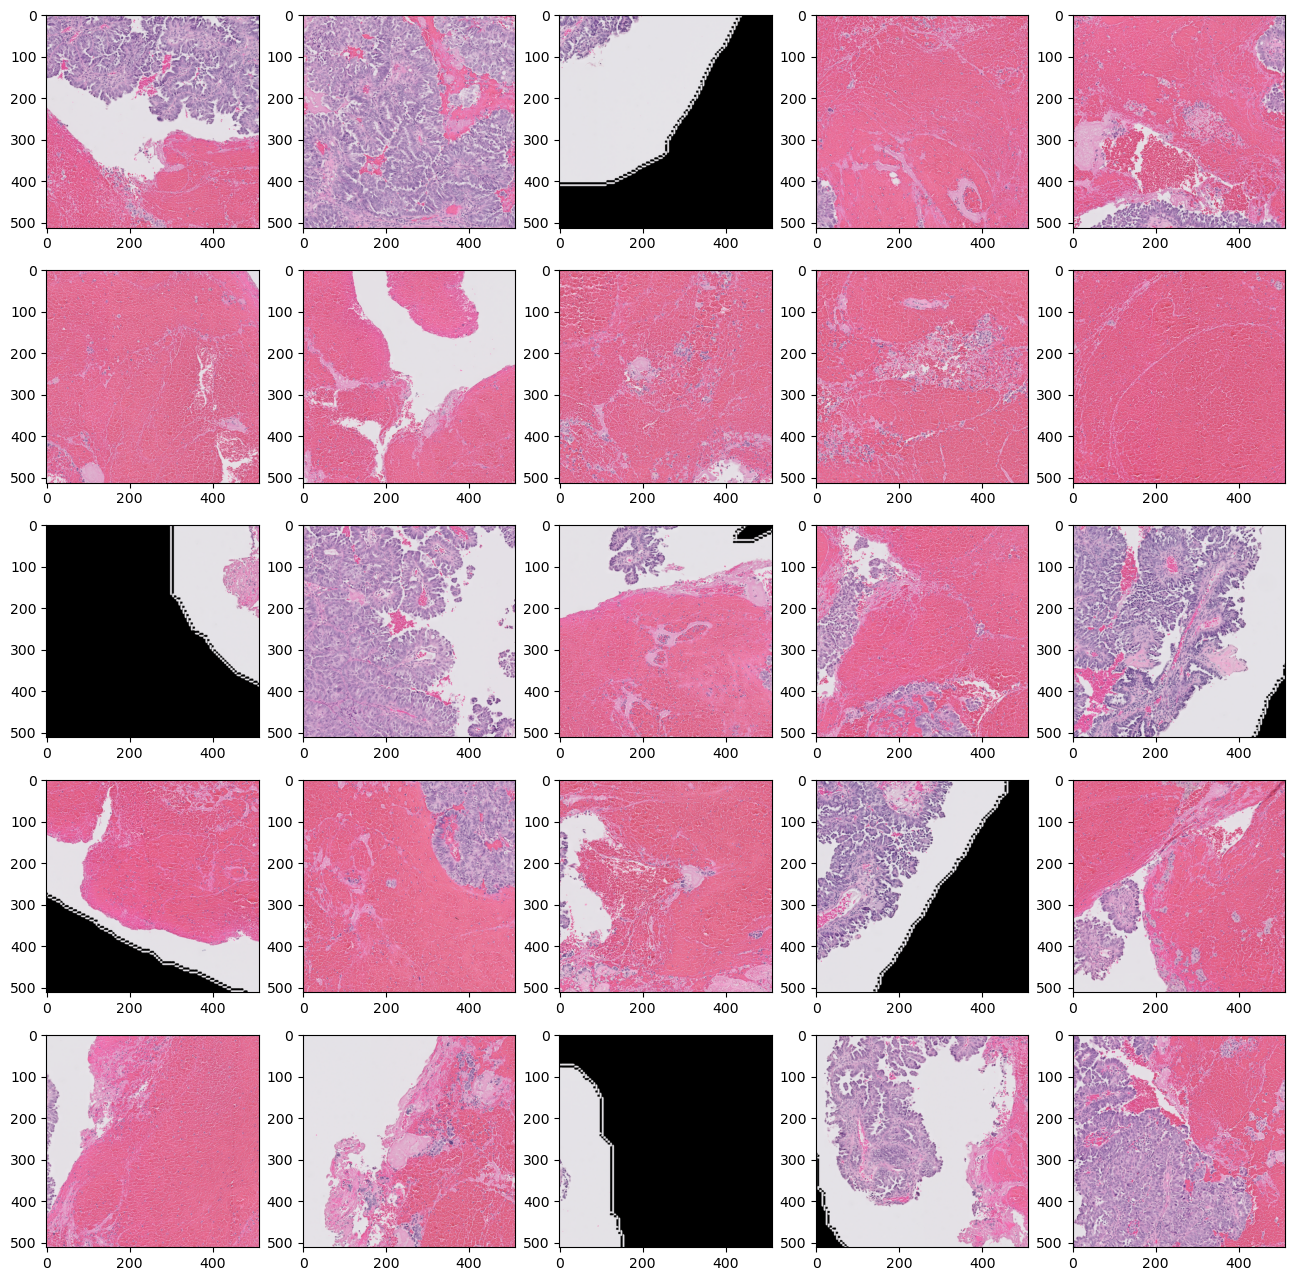

In [5]:
ls = [p for p in glob.glob(out_dir + '/*') if os.path.isdir(p)]
print(f"found folders: {len(ls)}")
ls = glob.glob(out_dir + '/*/*.png')
print(f"found images: {len(ls)}")

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(16, 16))
for i, p_img in enumerate(ls[:25]):
    img = plt.imread(p_img)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)